# 💧 Explore the World Water Map with Python

<a target="_blank" href="https://colab.research.google.com/github/pgzmnk/walkthroughs/blob/main/notebooks/WorldWaterMap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook shows how you can create your own visuals and narratives from the [World Water Map](https://livingatlas.arcgis.com/wwm-insights) dataset.

The dataset forecasts the risk of water shortages and diminishing water supplies worldwide. It was published by [Mark Biergerns](https://www.uu.nl/staff/MFPBierkens) and his team at [Utrecht University](https://www.uu.nl/en) in collaboration with [National Geographic](http://nationalgeographic.org/) and [ESRI](https://www.esri.com/en-us/home).

By immersing yourself in this dataset, you'll gain insights into where and why water gaps occur, how they may worsen, and strategies to manage them. Most importantly, by following this notebook, you'll be able to to download the data for your region of choice and perform an analysis for your own storytelling pursuits.

This notebook demonstrates how to analyze and visualize global water demand data using Python. The steps include:

- **Downloading Data** – Retrieve relevant datasets for analysis.
- **Time Series Analysis** – Generate a simple time series plot to explore trends.
- **Stacked Time Series Plot** – Visualize multiple water demand components over time.
- **Mapping Water Demand** – Create a spatial representation of water demand from a GeoTIFF file.
- **Comparing Water Demand Over Time** – Map the difference in water demand between 1980 and 2019.

In [10]:
!pip install leafmap rasterio localtileserver -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00


# 1. Download files

In [11]:
import os
import zipfile
import requests
from io import BytesIO

# URL of the ZIP file
url = "https://lulctimeseries.blob.core.windows.net/ngs-wwm-2024/Country/cn_MX.zip"

# Destination folder
destination_folder = "/content/wwm/mx/"

# Ensure the destination directory exists
os.makedirs(destination_folder, exist_ok=True)

# Download the ZIP file
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Extract ZIP contents
with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extraction complete. Files are saved in {destination_folder}")


Extraction complete. Files are saved in /content/wwm/mx/


The files will be downloaded to a directory with this structure.

- `Rasters` contains GeoTIFF files by year and by statistical measure.
- `Vector_and_Tables` contains a georeferenced shapefile of the geography and a set of CSV
of modeled water statistics.

<img src="https://geoml-fused.s3.us-west-2.amazonaws.com/images/wwm_directory.png" alt="Files" width="400">

# 2. Simple timeseries plot

In [12]:
import pandas as pd

df = pd.read_csv("/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_demand_historical_total.csv")
df.tail()

Country            Variable  Year           SUM
35  Mexico  total_gross_demand  2015  9.594596e+10
36  Mexico  total_gross_demand  2016  1.044630e+11
37  Mexico  total_gross_demand  2017  1.095288e+11
38  Mexico  total_gross_demand  2018  1.027804e+11
39  Mexico  total_gross_demand  2019  1.096885e+11

In [13]:
df.nlargest(5, "SUM")

Country            Variable  Year           SUM
31  Mexico  total_gross_demand  2011  1.213943e+11
29  Mexico  total_gross_demand  2009  1.129811e+11
32  Mexico  total_gross_demand  2012  1.108611e+11
39  Mexico  total_gross_demand  2019  1.096885e+11
25  Mexico  total_gross_demand  2005  1.096652e+11

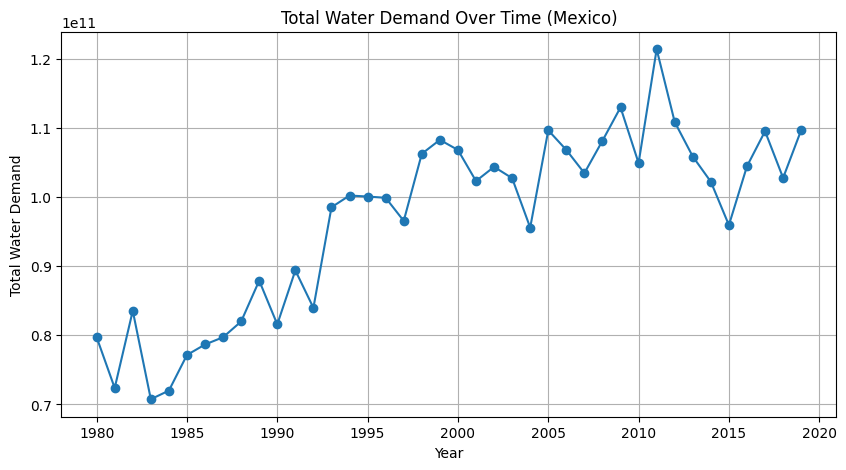

In [14]:
import matplotlib.pyplot as plt

# Plot timeseries
plt.figure(figsize=(10, 5))
plt.plot(df["Year"], df["SUM"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Water Demand")
plt.title("Total Water Demand Over Time (Mexico)")
plt.grid(True)
plt.show()


# 3. Stacked timeseries plot

In [15]:
csv_files = [
    "/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_demand_historical_total.csv",
    "/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_withdrawal_historical_total.csv",
    "/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_gap_historical_total.csv",
    "/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_abstraction_historical_total.csv",
    "/content/wwm/mx/Vector_and_Tables/cn_MX_cntry_abstraction_historical_nonrenewable.csv"
]

In [16]:
# Read all CSVs into dataframes
dfs = [pd.read_csv(f) for f in csv_files]

# Concatenate
df = pd.concat(dfs, ignore_index=True)

# Pivot without aggregation
merged_df = df.pivot(index=["Country", "Year"], columns="Variable", values="SUM").reset_index()

# Display result
merged_df.head()


Variable Country  Year  nonrenewable_abstraction  total_abstraction  \
0         Mexico  1980              9.390322e+09       3.121681e+10   
1         Mexico  1981              8.388647e+09       3.168340e+10   
2         Mexico  1982              1.106502e+10       3.353985e+10   
3         Mexico  1983              8.607545e+09       2.785910e+10   
4         Mexico  1984              8.107113e+09       3.050792e+10   

Variable  total_gross_demand  total_water_gap  total_water_withdrawal  
0               7.972995e+10     4.851033e+10            4.017816e+10  
1               7.238293e+10     4.353535e+10            3.683399e+10  
2               8.354949e+10     5.290603e+10            4.124550e+10  
3               7.075646e+10     4.472385e+10            3.437123e+10  
4               7.200270e+10     4.330245e+10            3.647320e+10

In [17]:
import plotly.express as px

# Reshape the DataFrame to long format
df_long = merged_df.melt(id_vars=["Year", "Country"],
                  value_vars=[
                      "nonrenewable_abstraction",
                      "total_gross_demand",
                      "total_abstraction",
                      "total_water_gap",
                      "total_water_withdrawal"
                      ],
                  var_name="Category",
                  value_name="Water Volume")


custom_colors = {
    "total_water_gap": "red",                  # Gap → Red
    "total_water_withdrawal": "blue",          # Total Abstraction → Blue
    "nonrenewable_abstraction": "lightblue",   # Nonrenewable → Light Blue
    "total_gross_demand": "brown",             # Total Demand → Brown
    "total_abstraction": "pink"                # Total Abstraction → Pink
}


# Create the interactive stacked area plot
fig = px.area(df_long, x="Year", y="Water Volume", color="Category",
               color_discrete_map=custom_colors,
              line_group="Country", labels={"Water Volume": "Water Volume (m³)", "Category": "Water Use Type"},
              title="Stacked Time Series of Water Usage",
              hover_data={"Year": True, "Country": True, "Water Volume": ":,.0f"})


fig.update_traces(opacity=1)

fig.update_layout(hovermode="x unified")
fig.show()


# 4. Map GeoTIFF

In [18]:
import leafmap
import geopandas as gpd

tiff_path = "/content/wwm/mx/Rasters/Historical/cn_MX_1980_demand_historical_total.tif"

# Create an interactive map
m = leafmap.Map()
m.add_basemap("Esri.NatGeoWorldMap")

layer1 = "Historical Demand 1980"
m.add_raster(tiff_path, colormap="inferno", layer_name=layer1, nodata=0)

# Add shapefile
shapefile_path = "/content/wwm/mx/Vector_and_Tables/cn_MX.shp"
gdf = gpd.read_file(shapefile_path)
m.add_gdf(gdf, layer_name="Shapefile")

# Display the map
m


Map(center=[23.624997, -102.541662], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

# 5. Map GeoTIFFs delta

In [ ]:
import whitebox
wbt = whitebox.WhiteboxTools()

# Path to GeoTIFF files
tiff_path1 = "/content/wwm/mx/Rasters/Historical/cn_MX_1980_demand_historical_total.tif"
tiff_path2 = "/content/wwm/mx/Rasters/Historical/cn_MX_2019_demand_historical_total.tif"

# Calculate difference between two GeoTIFFs
chm = wbt.subtract(tiff_path1, tiff_path2, '/content/chm.tif')

In [20]:
# Create an interactive map
m = leafmap.Map()
m.add_basemap("Esri.NatGeoWorldMap")

# Add the delta raster layer
m.add_raster("/content/chm.tif", colormap="inferno", layer_name="Difference", nodata=0)

# Add shapefile
shapefile_path = "/content/wwm/mx/Vector_and_Tables/cn_MX.shp"
gdf = gpd.read_file(shapefile_path)
m.add_gdf(gdf, layer_name="Shapefile")

# Display the map
m

Map(center=[23.624997, -102.541662], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…